In [1]:
# Param
test = "True"

In [2]:
is_test = True
if test == "False" or test == False:
    is_test = False

In [3]:
# Set the dataset path
dataset = "data"

In [4]:
# Import utility functions for data loading and path joining
from utils.data_loader import DataLoader
from utils.data_io import join_path

In [5]:
# Initialize the data loader with the dataset path
data_loader = DataLoader(dataset)

In [6]:
# Load training and test data
train_df = data_loader.get_data_train()
test_df = data_loader.get_data_test()

In [7]:
# Get data description (column names for labels and text)
data_desc = data_loader.get_data_desc()
label_column = data_desc['label_column']
text_column = data_desc['text_column']

In [8]:
# Extract and print keyword concepts
keyword_concepts = data_loader.get_keyword_concepts()
keywords = []
for k in keyword_concepts.keys():
    keywords += keyword_concepts[k]

keyword_concepts = keywords
print(keyword_concepts)

['hemorrhage', 'inflammatory', 'pregnancy', 'growth', 'cardiac', 'cancer', 'carcinoma', 'malignancy', 'metastasis', 'malignant', 'gastrointestinal', 'biliary', 'cirrhosis', 'esophageal', 'ulcer', 'seizure', 'neurologic', 'nerve', 'spinal cord', 'cognitive deficit', 'coronary', 'ventricular', 'myocardial', 'systolic', 'hypertensive']


In [9]:
# Extract abstract concepts
abstract_concepts = data_loader.get_abstract_concepts()
abstract_concepts = [ac['abstract_concept_name'] for ac in abstract_concepts]
print(abstract_concepts)

['Hemorrhagic and Inflammatory Processes', 'Reproductive and Growth Abnormalities', 'Cardiovascular Pathologies', 'Neoplastic Growth and Spread', 'Gastrointestinal and Biliary System Disorders', 'Neurological and Spinal Cord Conditions']


In [10]:
# Import LabelEncoder for encoding labels
from sklearn.preprocessing import LabelEncoder

In [11]:
# Encode labels in training and test data
le = LabelEncoder()
le.fit(train_df[label_column])
train_df[label_column] = le.transform(train_df[label_column])
test_df[label_column] = le.transform(test_df[label_column])

In [12]:
# Get the list of label names
label_concepts = list(le.classes_)
print(label_concepts)

['cardiovascular diseases', 'digestive system diseases', 'general pathological conditions', 'neoplasms', 'nervous system diseases']


In [ ]:
# If in test mode, sample one example per label
if is_test:
    train_df = train_df.groupby(label_column).sample(1)
    test_df = test_df.groupby(label_column).sample(1)

In [14]:
from sklearn.model_selection import train_test_split

train_texts = train_df[text_column].tolist()
train_labels = train_df[label_column].tolist()
test_texts = test_df[text_column].tolist()
test_labels = test_df[label_column].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def precompute_split(model, tokenizer, text_splits, concepts, batchsize=512):
    """
    text_splits: dict chứa {'train': texts, 'val': texts, 'test': texts}
    returns: dict chứa {'train': scores_tensor, 'val': scores_tensor, 'test': scores_tensor}
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    concept_len = len(concepts)

    results = {}

    for split_name, split_texts in text_splits.items():
        print(f"Precomputing for [{split_name}] with {len(split_texts)} texts...")
        num_texts = len(split_texts)
        scores = torch.zeros((num_texts, concept_len))

        for i in tqdm(range(0, num_texts, batchsize), desc=f"{split_name} Texts"):
            text_batch = split_texts[i:i + batchsize]
            for j in range(0, concept_len, batchsize):
                concept_batch = concepts[j:j + batchsize]
                pairs = [(t, c) for t in text_batch for c in concept_batch]

                inputs = tokenizer.batch_encode_plus(
                    pairs,
                    padding=True,
                    truncation=True,
                    return_tensors="pt",
                    max_length=128
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = torch.softmax(outputs.logits, dim=1)
                    entailment_scores = probs[:, 1]  # score for entailment class

                k = 0
                for m in range(len(text_batch)):
                    for n in range(len(concept_batch)):
                        scores[i + m][j + n] = entailment_scores[k].item()
                        k += 1

        results[split_name] = scores

    return results

In [16]:
# train_keyword_scores = [[0 for _ in range(len(keyword_concepts))] for _ in range(len(train_texts))]
# val_keyword_scores = [[0 for _ in range(len(keyword_concepts))] for _ in range(len(val_texts))]
# test_keyword_scores = [[0 for _ in range(len(keyword_concepts))] for _ in range(len(test_texts))]

# train_abstract_scores = [[0 for _ in range(len(abstract_concepts))] for _ in range(len(train_texts))]
# val_abstract_scores = [[0 for _ in range(len(abstract_concepts))] for _ in range(len(val_texts))]
# test_abstract_scores = [[0 for _ in range(len(abstract_concepts))] for _ in range(len(test_texts))]

In [17]:
from transformers import BertTokenizer, BertForSequenceClassification

def load_nli_model(path):
    model = BertForSequenceClassification.from_pretrained(path)
    tokenizer = BertTokenizer.from_pretrained(path)
    return model, tokenizer

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

keyword_model_path = join_path(dataset, 'scorer_model', 'keyword_scorer')
abstract_model_path = join_path(dataset, 'scorer_model', 'abstract_scorer')

keyword_model, keyword_tokenizer = load_nli_model(keyword_model_path)
abstract_model, abstract_tokenizer = load_nli_model(abstract_model_path)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
text_splits = {
    "train": train_texts,
    "val": val_texts,
    "test": test_texts
}

# Precompute keyword scores
keyword_score_splits = precompute_split(keyword_model, keyword_tokenizer, text_splits, keyword_concepts)

train_keyword_scores = keyword_score_splits["train"]
val_keyword_scores = keyword_score_splits["val"]
test_keyword_scores = keyword_score_splits["test"]

# Precompute abstract scores
abstract_score_splits = precompute_split(abstract_model, abstract_tokenizer, text_splits, abstract_concepts)

train_abstract_scores = abstract_score_splits["train"]
val_abstract_scores = abstract_score_splits["val"]
test_abstract_scores = abstract_score_splits["test"]


Precomputing for [train] with 40 texts...


train Texts:   0%|          | 0/3 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned 

Precomputing for [val] with 10 texts...


val Texts:   0%|          | 0/1 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned fo

Precomputing for [test] with 50 texts...


test Texts:   0%|          | 0/4 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned f

Precomputing for [train] with 40 texts...


train Texts:   0%|          | 0/3 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned 

Precomputing for [val] with 10 texts...


val Texts:   0%|          | 0/1 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned fo

Precomputing for [test] with 50 texts...


test Texts:   0%|          | 0/4 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned f

In [20]:
def get_score_subset(score_matrix, text_batch, concepts, text_to_idx, concept_to_idx):
    direct_scores = torch.zeros((len(concepts), len(text_batch)))
    for i, concept in enumerate(concepts):
        for j, text in enumerate(text_batch):
            direct_scores[i][j] = score_matrix[text_to_idx[text]][concept_to_idx[concept]]
    return direct_scores

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConceptNetwork(nn.Module):
    def __init__(self, keyword_concepts, abstract_concepts, label_concepts, embedding_dim=64):
        super().__init__()
        self.k_concepts = keyword_concepts
        self.a_concepts = abstract_concepts
        self.l_concepts = label_concepts
        d = embedding_dim

        self.keyword_emb = nn.Parameter(torch.randn(len(self.k_concepts), d))
        self.abstract_emb = nn.Parameter(torch.randn(len(self.a_concepts), d))
        self.label_emb = nn.Parameter(torch.randn(len(self.l_concepts), d))

        self.keyword_beta = nn.Parameter(torch.rand(len(self.k_concepts)))
        self.abstract_beta = nn.Parameter(torch.rand(len(self.a_concepts)))

        # concept -> index mapping
        self.k_idx = {c: i for i, c in enumerate(self.k_concepts)}
        self.a_idx = {c: i for i, c in enumerate(self.a_concepts)}
        self.l_idx = {c: i for i, c in enumerate(self.l_concepts)}

    def forward(self, text_batch, keyword_scores_all, abstract_scores_all, text_to_idx):
        b = len(text_batch)

        # keyword scores: [m x b]
        k_scores = get_score_subset(keyword_scores_all, text_batch, self.k_concepts, text_to_idx, self.k_idx)
        a_scores = get_score_subset(abstract_scores_all, text_batch, self.a_concepts, text_to_idx, self.a_idx)

        # attention: abstract -> keyword
        attn = F.softmax(torch.matmul(self.abstract_emb, self.keyword_emb.T), dim=1)  # [n x m]
        rel_a_scores = torch.matmul(attn, k_scores)  # [n x b]

        total_abstract_scores = a_scores + rel_a_scores  # [n x b]
        abstract_weights = F.softmax(self.abstract_beta.view(-1, 1), dim=0)  # [n x 1]

        abstract_context = torch.matmul(self.abstract_emb.T, total_abstract_scores * abstract_weights)  # [d x b]
        logits = torch.matmul(self.label_emb, abstract_context).T  # [b x p]

        return logits

In [22]:
from sklearn.metrics import accuracy_score

def evaluate(model, texts, labels, keyword_scores, abstract_scores, text_to_idx):
    model.eval()
    preds = []

    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = texts[i:i+32]
            logits = model(batch, keyword_scores, abstract_scores, text_to_idx)
            preds.extend(torch.argmax(logits, dim=1).cpu().tolist())

    return accuracy_score(labels, preds)

In [23]:
import matplotlib.pyplot as plt

In [24]:
def train(model,
          train_texts, val_texts,
          train_labels, val_labels,
          train_keyword_scores, train_abstract_scores, train_text_idx,
          val_keyword_scores, val_abstract_scores, val_text_idx,
          num_epochs=10,
          lr=1e-3):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_arr = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0

        for i in range(0, len(train_texts), 32):
            batch_texts = train_texts[i:i+32]
            batch_labels = torch.tensor(train_labels[i:i+32], dtype=torch.long).to(device)

            logits = model(batch_texts, train_keyword_scores, train_abstract_scores, train_text_idx)
            loss = criterion(logits, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f}")
        loss_arr.append(total_loss)

        # Evaluate on validation set
        acc = evaluate(
            model,
            val_texts, val_labels,
            keyword_scores=val_keyword_scores,
            abstract_scores=val_abstract_scores,
            text_to_idx=val_text_idx
        )
        print(f"→ Val Acc: {acc:.4f}")

    plt.plot(loss_arr)
    plt.show()


[Epoch 1] Train Loss: 6.0604
→ Val Acc: 0.3000
[Epoch 2] Train Loss: 5.8426
→ Val Acc: 0.3000
[Epoch 3] Train Loss: 5.6385
→ Val Acc: 0.3000
[Epoch 4] Train Loss: 5.4451
→ Val Acc: 0.3000
[Epoch 5] Train Loss: 5.2609
→ Val Acc: 0.3000
[Epoch 6] Train Loss: 5.0853
→ Val Acc: 0.2000
[Epoch 7] Train Loss: 4.9179
→ Val Acc: 0.2000
[Epoch 8] Train Loss: 4.7590
→ Val Acc: 0.2000
[Epoch 9] Train Loss: 4.6086
→ Val Acc: 0.2000
[Epoch 10] Train Loss: 4.4671
→ Val Acc: 0.3000
[Epoch 11] Train Loss: 4.3348
→ Val Acc: 0.3000
[Epoch 12] Train Loss: 4.2122
→ Val Acc: 0.3000
[Epoch 13] Train Loss: 4.0996
→ Val Acc: 0.3000
[Epoch 14] Train Loss: 3.9970
→ Val Acc: 0.3000
[Epoch 15] Train Loss: 3.9045
→ Val Acc: 0.3000
[Epoch 16] Train Loss: 3.8215
→ Val Acc: 0.3000
[Epoch 17] Train Loss: 3.7476
→ Val Acc: 0.3000
[Epoch 18] Train Loss: 3.6819
→ Val Acc: 0.3000
[Epoch 19] Train Loss: 3.6235
→ Val Acc: 0.3000
[Epoch 20] Train Loss: 3.5716
→ Val Acc: 0.3000
[Epoch 21] Train Loss: 3.5256
→ Val Acc: 0.2000
[

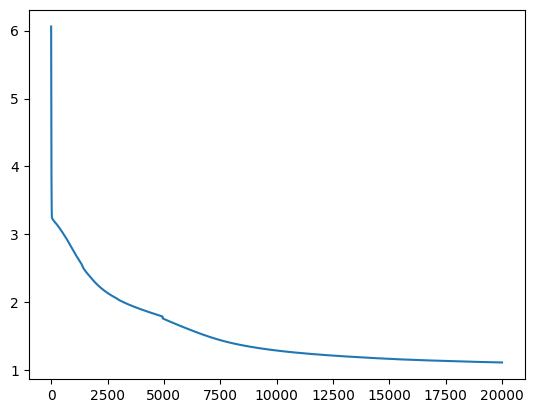

In [ ]:
train_text_idx = {t: i for i, t in enumerate(train_texts)}
val_text_idx   = {t: i for i, t in enumerate(val_texts)}

concept_model = ConceptNetwork(keyword_concepts, abstract_concepts, label_concepts, embedding_dim=64)

train(
    concept_model,
    train_texts, val_texts,
    train_labels, val_labels,
    train_keyword_scores, train_abstract_scores, train_text_idx,
    val_keyword_scores, val_abstract_scores, val_text_idx,
    num_epochs=5000
)


In [26]:
from sklearn.metrics import classification_report, accuracy_score

def test(model, test_texts, test_labels, keyword_scores, abstract_scores, text_to_idx, label_names=None):
    model.eval()
    preds = []

    with torch.no_grad():
        for i in range(0, len(test_texts), 32):
            batch = test_texts[i:i+32]
            logits = model(batch, keyword_scores, abstract_scores, text_to_idx)
            preds.extend(torch.argmax(logits, dim=1).cpu().tolist())

    acc = accuracy_score(test_labels, preds)
    print(f"Test Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(test_labels, preds, target_names=label_names))

    return acc, preds

In [27]:
test_text_idx = {t: i for i, t in enumerate(test_texts)}

acc, preds = test(
    concept_model,
    test_texts,
    test_labels,
    keyword_scores=test_keyword_scores,
    abstract_scores=test_abstract_scores,
    text_to_idx=test_text_idx,
    label_names=label_concepts
)

Test Accuracy: 0.3400

Classification Report:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.18      0.20      0.19        10
      digestive system diseases       0.43      0.30      0.35        10
general pathological conditions       0.31      0.40      0.35        10
                      neoplasms       0.50      0.30      0.38        10
        nervous system diseases       0.38      0.50      0.43        10

                       accuracy                           0.34        50
                      macro avg       0.36      0.34      0.34        50
                   weighted avg       0.36      0.34      0.34        50

